We are going to implement a classification algorithm with a Feed Forward Fully Connected Neural Network, also called Multi Layer Perceptron (MLP).  

In [15]:
%matplotlib inline  

import os
import gzip
from time import time
from copy import deepcopy as cp
import typing as tp
import operator
import warnings
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as skm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
# this function takes col category and returns as Y (target), the other columns are X (labels)
def split_X_Y(data):
    Y = data['category']
    X = data.drop('category',axis=1)

    return X,Y

# this function divides the dataset in input in parts_to_be_split parts. One of them is returned as test_set
# the other ones are the training_set. Indexes of the chosen data can be accessed (test_indexes, train_indexes)
# (for example in a K-fold)

def split_train_test_set(data,parts_to_be_split):
    indexes = np.arange(0,data.shape[0],1)
    rnd.shuffle(indexes)
    len_test_set = int(len(indexes) / parts_to_be_split)

    test_indexes = indexes[:len_test_set]
    train_indexes = indexes[len_test_set:]

    train_set = data.iloc[train_indexes]
    test_set = data.iloc[test_indexes]
    
    return train_set, test_set

In [ ]:
file_name="/home/samu/LaboratoryOfComputationalPhysics_Y7/Project/magic04.data"
data = pd.DataFrame(pd.read_csv(file_name))
data.columns=['fLength','fWidth','fSize',
        'fConc','fConc1','fAsym',
        'fM3Long','fM3Trans','fAlpha','fDist','category']



train_set, test_set = split_train_test_set(data,5)
X_train,Y_train = split_X_Y(train_set)
X_test,Y_test = split_X_Y(test_set)
Y_train = np.array(np.where(Y_train == 'g', 1, -1))
Y_test  = np.array(np.where(Y_test == 'g', 1, -1))

print('shape of train_set:',np.shape(X_train),np.shape(Y_train))
print('shape of train_set:',np.shape(X_test),np.shape(Y_test))
print(X_train,Y_train)


We choose the RELU activation function for the hidden layers (most frequent choice) and the Stochastic Gradient Descent method to compute the weights with Backpropagation. Thus, the hyper-parameters of the hypothesis class we have to tune are the **architecture of the network** (number of hidden layers and neurons in each hidden layer) and the **learning rate**. We implement a grid search to find the combination of these parameters that maximizes the partial area under the ROC curve, up until a false positive rate FPR $\le$ 0.2.      

In [6]:
###### first method


parameters = {'hidden_layer_sizes': [(18,), (36,), (54), (36,18), (54,18), (54,36), (54,36,18)],'learning_rate_init': [0.1,0.01,0.001]}

MLP=MLPClassifier(activation = 'relu', max_iter = 300, alpha = 1e-4, solver = 'sgd',tol = 1e-4, learning_rate = 'adaptive')

# this function determines the partial area under the curve, up to FPR<=0.2
def partial_auc_at_fpr(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    valid_indices = fpr <= 0.2  # indices where FPR <= 0.2
    partial_fpr = fpr[valid_indices]
    partial_tpr = tpr[valid_indices]
    # check if there are at least 2 points for partial AUC calculation
    if len(partial_fpr) < 2:
        return 0  # return 0 if not enough points to calculate AUC

    partial_auc = auc(partial_fpr, partial_tpr)
    return partial_auc

# create scoring function (partial AUC) to implement a grid-search
partial_auc_scorer = make_scorer(partial_auc_at_fpr, greater_is_better=True)

# to print the results after each combination is evaluated
class VerboseGridSearchCV(GridSearchCV):
    def _run_search(self, evaluate_candidates):
        super()._run_search(evaluate_candidates)
        
        # print the partial AUC after each parameter evaluation
        for i, params in enumerate(self.cv_results_['params']):
            mean_score = self.cv_results_['mean_test_score'][i]
            print(f"Parameters: {params} - Partial AUC: {mean_score}")

# implement the grid-search to maximize the partial AUC (5-fold cross-validation)
grid_search = VerboseGridSearchCV(estimator=MLP, param_grid=parameters, scoring=partial_auc_scorer, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_,)
print("Best partial AUC (Training set):", grid_search.best_score_)

# evaluate the best model on the test set and plot its ROC curve
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
partial_fpr = fpr[fpr <= 0.2]
partial_tpr = tpr[fpr <= 0.2]
test_partial_auc = auc(partial_fpr, partial_tpr)
print("Best partial AUC (Test set):", test_partial_auc)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


/home/samu/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/samu/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/samu/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/samu/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/samu/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:205: Runtime

AttributeError: 'VerboseGridSearchCV' object has no attribute 'cv_results_'

In [7]:
################# alternative method   ###############


from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definizione degli iperparametri da testare
parameters = {'hidden_layer_sizes': [(18,), (36,), (54,), (36,18), (54,18), (54,36), (54,36,18)],
              'learning_rate_init': [0.1,0.01,0.001]}

# Creazione del classificatore MLP
MLP = MLPClassifier(activation='relu', max_iter=600, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate='adaptive')


#### full auc scorer
def full_auc_scorer(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    return auc(fpr, tpr)

auc_scorer = make_scorer(full_auc_scorer, greater_is_better=True, response_method='predict' ) 
### need_proba si gonna be deprecated, substituted with response_method='predict' for same results

## to print the results after each combination is evaluated
class VerboseGridSearchCV(GridSearchCV):
    def fit(self, X, y=None, **fit_params):
        super().fit(X, y, **fit_params)  # Esegue la ricerca a griglia normalmente

        for i, params in enumerate(self.cv_results_['params']):
            mean_score = self.cv_results_['mean_test_score'][i]
            print(f"Parameters: {params} - AUC: {mean_score}")
            
## implement the grid-search to maximize the partial AUC (5-fold cross-validation)
grid_search = VerboseGridSearchCV(estimator=MLP, param_grid=parameters, scoring=auc_scorer, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best AUC (Training set):", grid_search.best_score_)

#### partial AUC  and best model

best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  


fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
auc_value = auc(fpr, tpr)
print("AUC (Test set):", auc_value)

partial_fpr = fpr[fpr <= 0.2]
partial_tpr = tpr[:len(partial_fpr)]
partial_auc = auc(partial_fpr, partial_tpr)
print("Partial AUC (Test set, FPR<=0.2):", partial_auc)



Fitting 5 folds for each of 21 candidates, totalling 105 fits
Parameters: {'hidden_layer_sizes': (18,), 'learning_rate_init': 0.1} - AUC: 0.5034733104659855
Parameters: {'hidden_layer_sizes': (18,), 'learning_rate_init': 0.01} - AUC: 0.7422134260240983
Parameters: {'hidden_layer_sizes': (18,), 'learning_rate_init': 0.001} - AUC: 0.7869674277759108
Parameters: {'hidden_layer_sizes': (36,), 'learning_rate_init': 0.1} - AUC: 0.5476592844075782
Parameters: {'hidden_layer_sizes': (36,), 'learning_rate_init': 0.01} - AUC: 0.7825696461262216
Parameters: {'hidden_layer_sizes': (36,), 'learning_rate_init': 0.001} - AUC: 0.7835375047799206
Parameters: {'hidden_layer_sizes': (54,), 'learning_rate_init': 0.1} - AUC: 0.548674802401943
Parameters: {'hidden_layer_sizes': (54,), 'learning_rate_init': 0.01} - AUC: 0.7842060116597657
Parameters: {'hidden_layer_sizes': (54,), 'learning_rate_init': 0.001} - AUC: 0.7868287950839471
Parameters: {'hidden_layer_sizes': (36, 18), 'learning_rate_init': 0.1} - A

In [9]:
#print(models.best_params_['hidden_layer_sizes'])
#best_model=MLPClassifier(activation = 'relu', hidden_layer_sizes = models.best_params_['hidden_layer_sizes'], learning_rate_init=models.best_params_['learning_rate_init'], max_iter = 200, alpha = 1e-4, solver = 'sgd',tol = 1e-4, learning_rate = 'adaptive')


best_model.fit(X_train,Y_train)
best_pred = best_model.predict(X_test)
accuracy = skm.accuracy_score(Y_test, best_pred)


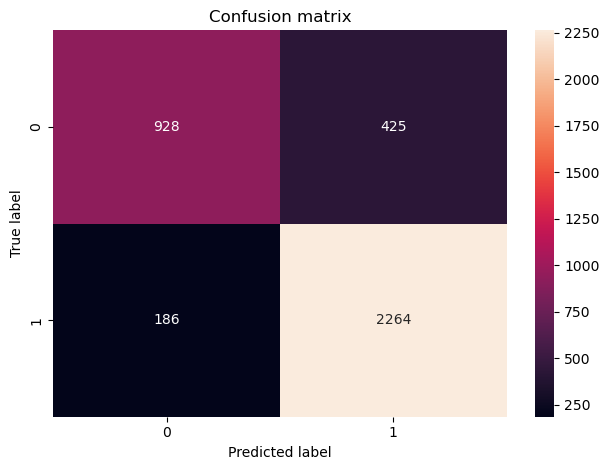

[CV] END ...hidden_layer_sizes=(36,), learning_rate_init=0.1; total time=   2.0s
[CV] END .hidden_layer_sizes=(36,), learning_rate_init=0.001; total time=   4.8s
[CV] END hidden_layer_sizes=(36, 18), learning_rate_init=0.01; total time=   2.8s
[CV] END hidden_layer_sizes=(54, 18), learning_rate_init=0.01; total time=   5.5s
[CV] END hidden_layer_sizes=(54, 36), learning_rate_init=0.1; total time=   3.8s
[CV] END hidden_layer_sizes=(54, 36), learning_rate_init=0.001; total time=  11.0s
[CV] END ..hidden_layer_sizes=(18,), learning_rate_init=0.01; total time=   1.5s
[CV] END ..hidden_layer_sizes=(36,), learning_rate_init=0.01; total time=   3.2s
[CV] END ..hidden_layer_sizes=(54,), learning_rate_init=0.01; total time=   7.3s
[CV] END hidden_layer_sizes=(54, 18), learning_rate_init=0.1; total time=   3.1s
[CV] END hidden_layer_sizes=(54, 18), learning_rate_init=0.001; total time=   8.6s
[CV] END hidden_layer_sizes=(54, 36, 18), learning_rate_init=0.01; total time=   3.8s
[CV] END ...hidde

[CV] END ..hidden_layer_sizes=(18,), learning_rate_init=0.01; total time=   2.8s
[CV] END ......hidden_layer_sizes=54, learning_rate_init=0.1; total time=   2.1s
[CV] END ....hidden_layer_sizes=54, learning_rate_init=0.001; total time=   7.6s
[CV] END hidden_layer_sizes=(54, 18), learning_rate_init=0.01; total time=   5.3s
[CV] END hidden_layer_sizes=(54, 36), learning_rate_init=0.01; total time=   6.8s
[CV] END hidden_layer_sizes=(54, 36, 18), learning_rate_init=0.01; total time=   7.5s
[CV] END .hidden_layer_sizes=(18,), learning_rate_init=0.001; total time=   3.8s
[CV] END ...hidden_layer_sizes=(54,), learning_rate_init=0.1; total time=   2.3s
[CV] END hidden_layer_sizes=(36, 18), learning_rate_init=0.1; total time=   5.3s
[CV] END hidden_layer_sizes=(36, 18), learning_rate_init=0.001; total time=   8.4s
[CV] END hidden_layer_sizes=(54, 36), learning_rate_init=0.001; total time=  11.8s
[CV] END .hidden_layer_sizes=(18,), learning_rate_init=0.001; total time=   6.5s
[CV] END hidden_l

In [16]:
def plot_conf_matrix(conf_matrix: np.ndarray) -> None:
    sns.heatmap(conf_matrix, annot=True, fmt="d",)
    plt.title("Confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.tight_layout()
    plt.show()
    plt.close()

labels, freqs = np.unique(Y_test, return_counts=True) 
cm_NN = skm.confusion_matrix(Y_test, best_pred)
plot_conf_matrix(cm_NN)
